## **Loading the COCO dataset**
NOTE : Due to limited internet issues the dataset has not been downloaded and the process has been performed on single image.

## **The following is the link to the Face Detection performed using YOLO kindly have a look : https://colab.research.google.com/drive/1lwH6pUz-o7FRxxqSYAgUatsNkhYTag6I**

Downloading the files using the **wget** command



In [1]:
# !wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

This will unzip the files to the specified destination directory and remove all the *.zip files once each file has been unzipped.

In [2]:
# from zipfile import ZipFile, BadZipFile
# import os
# def extract_zip_file(extract_path):
#     try:
#         with ZipFile(extract_path+".zip") as zfile:
#             zfile.extractall(extract_path)
#         # remove zipfile
#         zfileTOremove=f"{extract_path}"+".zip"
#         if os.path.isfile(zfileTOremove):
#             os.remove(zfileTOremove)
#         else:
#             print("Error: %s file not found" % zfileTOremove)
#     except BadZipFile as e:
#         print("Error:", e)
# extract_train_path = "./coco_train2017"
# extract_val_path = "./coco_val2017"
# extract_ann_path="./coco_ann2017"
# extract_zip_file(extract_train_path)
# extract_zip_file(extract_val_path)
# extract_zip_file(extract_ann_path)

# **COCO class labels**

In [37]:
!cat coco.names | wc -l

80


In [38]:
!cat coco.names | head

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light


## **Importing Modules**

In [39]:
import cv2
import numpy as np
import os
import time

from matplotlib import pyplot as plt

In [40]:
img_name = 'horse.jpg'

# Reading image to an object (we will display it in the next step).
img = cv2.imread(img_name)

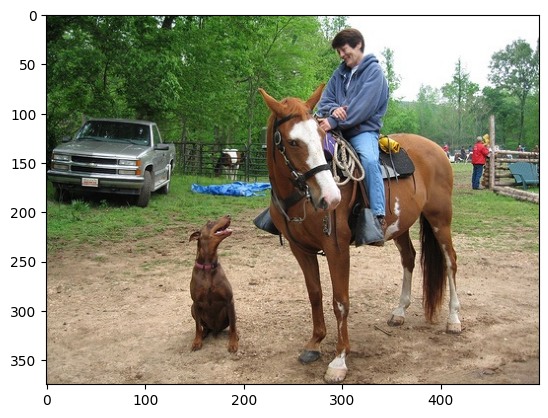

In [41]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## **Using YOLO for object detection**

In [10]:
#Downloading the file
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2023-12-14 06:52:33--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  31.8MB/s    in 9.6s    

2023-12-14 06:52:43 (24.7 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [42]:
# Load names of classes and get random colors for them.
classes = open('coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Give the configuration and weight files for the model and load the network.
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Show the network object
net

< cv2.dnn.Net 0x7dcaebbee5f0>

In [43]:
#Determine the output layer
# First, get layer names
ln = net.getLayerNames()
len(ln)

254

In [44]:
# Show names of all layers
print(ln)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [45]:
# Get output layers
net.getUnconnectedOutLayers()

array([200, 227, 254], dtype=int32)

In [46]:
# Show the names of this layers
try:
    print([ln[i[0] - 1] for i in net.getUnconnectedOutLayers()])
except IndexError:
    print([ln[i - 1] for i in net.getUnconnectedOutLayers()])

['yolo_82', 'yolo_94', 'yolo_106']


In [47]:
# Use this layers
try:
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

ln

['yolo_82', 'yolo_94', 'yolo_106']

Blob shape=(1, 3, 416, 416)


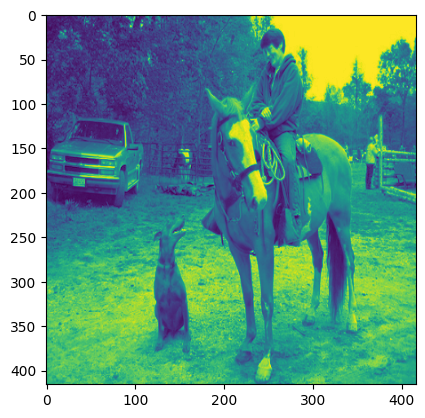

In [48]:
# Construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

plt.imshow(r)
print('Blob shape=%s' % (blob.shape,))

In [49]:
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('It took %.3f seconds to process the image.' % (t-t0))

It took 3.453 seconds to process the image.


In [50]:
print('Found %s objects.' % len(outputs))

print('\nEnlisting objects:')
print([out.shape for out in outputs])

Found 3 objects.

Enlisting objects:
[(507, 85), (2028, 85), (8112, 85)]


Image preview:


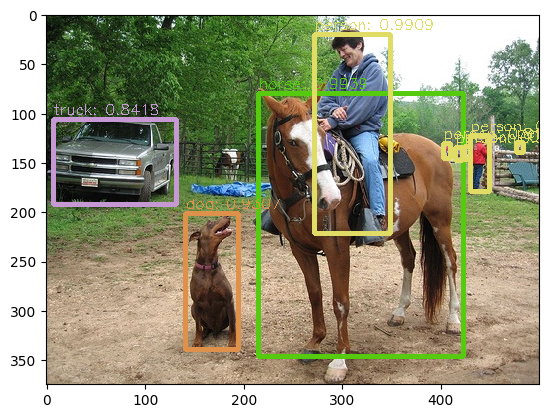

In [51]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]

        #  -- Arguments for CV2 rectangle:
        # cv2.rect   (img,  x, y,   width, height, color, line width)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 4)

        # Labels and confidences for the image
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

print('Image preview:')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')

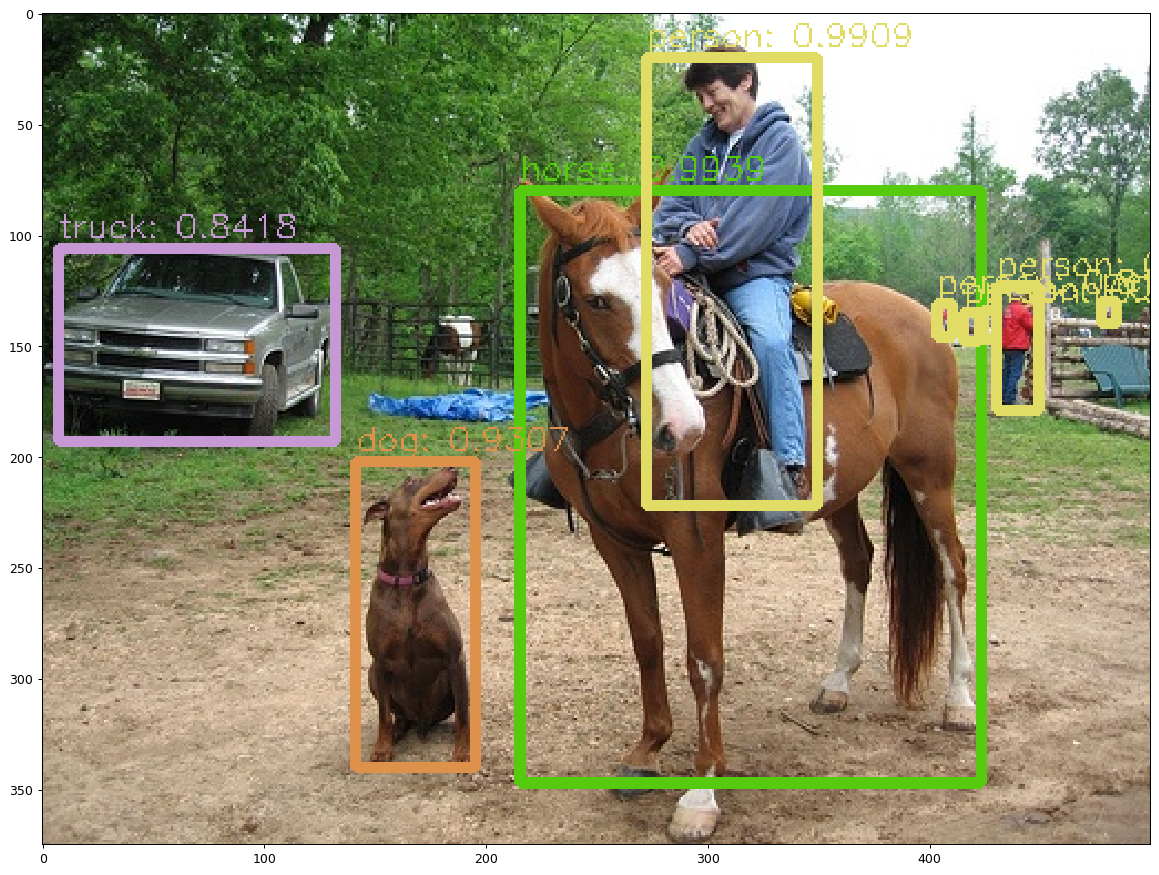

In [52]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=90)
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')